# Differentially expressed genes as identified in cells with cryptic| mitochondrial mutations

We use single-cell RNA-sequencing data from Enge et al. to demonstrate that we can identify DEGs.

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import argparse
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

import seaborn as sns

sns.set_context("paper")
sns.set_style("white")
sns.set(font_scale=1.2) 

## 0. Data loading and preparation

In [4]:
# Load the dataframe with mutation information
varianceData = pkl.load( open( "./../../data/precomputedData/Enge/engeVariantsSTAR200.pkl", "rb" ) )
# expression matrix
adata = sc.read_h5ad("./../../data/precomputedData/Enge/engeFilteredExpression200.h5ad")
# metadata
metadata = pkl.load( open( "./../../data/precomputedData/Enge/enge_metadata.pkl", "rb" ) )

In [5]:
# add age and cell type as annotations to the expression matrix 
# get all ages from the variance data
age = [ metadata[metadata['SRR_id'] == item]['donor_age'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# add it to the expression matrix
adata.obs['donor_age'] = age
# cellType = [ metadata[metadata['SRR_id'] == item]['inferred_cell_type'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# adata.obs['cell_type'] = cellType

In [6]:
# normalisation
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata)

In [7]:
# define a function that computes mitochondrial load and adds it to the data frame
def computeMitochondrialLoad(expressionMatrix,varianceDataFrame,
                             threshold = 0.05, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                             mutantType = 'all', # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                             removeSynonymous = 0, # whether to remove synonymous mutations from the mutations
                             pathologyType = 'all', # which type of pathology we look at
                             subsetCells = 'all', # whether to keep only certain type of cells
                             rescaling= False, # rescaling by considering the number of bases passed (not recommended)
                             muName = 'MU' # name given to the mitochondrial load in the expression matrix Anndata object
                            ): 
    
    # Apply heteroplasmy threshold 
    varianceDataFrame = varianceDataFrame[threshold<varianceDataFrame['HF']]
    
    # Keep only certain type of mutations
    if (mutantType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['mutant_type'].isin(mutantType)]
    
    # Keep only synonomous or non-synonomous mutation
    if removeSynonymous == True:
        varianceDataFrame= varianceDataFrame[~(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    elif (removeSynonymous == -1):
        # keep only synonomous mutations
        varianceDataFrame= varianceDataFrame[(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    
    # Keep only mutations of a certain pathology
    if (pathologyType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['MutPred_Prediction'].isin(pathologyType)]
    
    # Keep only certain cells
    if (subsetCells == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['sample_id'].isin(subsetCells)]
    
    # optional rescaling (it is easier to do this before the summation and the math works out)
    if (rescaling == True):
        varianceDataFrame['scalingFactor'] = 16569/varianceDataFrame['bases_passed']
        #varianceDataFrame['scalingFactor'][np.isinf(varianceDataFrame['scalingFactor'])] = 0
        varianceDataFrame['HF'] = varianceDataFrame.HF * varianceDataFrame.scalingFactor
        

    # compute the mitochondrial load
    groupedData = varianceDataFrame.groupby('sample_id') # group for each cell
    mu = groupedData.sum()['HF'] # mitochondrial load is then the sum over the heteroplasmies
    
    
    # add the mitoLoad as observable MU
    expressionMatrix.obs[muName] = mu
    expressionMatrix.obs[muName] = expressionMatrix.obs[muName] .fillna(0)
    
    return(expressionMatrix)

In [8]:
# DEG calculation 

def findDEGMitoLoad(expressionMatrix,varianceDataFrame,
                    threshold = 0.05, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                    mutantType = 'all', # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                    removeSynonymous = 0, # whether to remove synonymous mutations from the mutations
                    pathologyType = 'all', # which type of pathology we look at
                    subsetCells = 'all', # whether to keep only certain type of cells
                    muThreshold = 0.0, # threshold to divide cells into with or without mutation
                    significanceLevel=0.05, # if zero, all genes are returned
                    rescaling= False): # rescaling by considering the number of bases passed (not recommended)):
    
    # compute the mitochondrial load
    expressionMatrixMu = computeMitochondrialLoad(expressionMatrix,varianceDataFrame,threshold = threshold,mutantType = mutantType, # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                    removeSynonymous = removeSynonymous, # whether to remove synonymous mutations from the mutations
                    pathologyType = pathologyType, # which type of pathology we look at
                    subsetCells = subsetCells, # whether to keep only certain type of cells
                    rescaling= rescaling)
    
    
    # we need at least two cells with a mutation and two cells without
    nCellsWithMutation = np.sum(expressionMatrixMu.obs['MU'] >muThreshold)
    nCells = len(expressionMatrixMu.obs_names)
    if (   (nCellsWithMutation>1) & (nCellsWithMutation<nCells-1)  ):
        # create a new observable that is binary whether the mitoload is above a threshold
        maxMitoLoad = np.max(expressionMatrixMu.obs['MU'])
        expressionMatrixMu.obs['mitLoadBinary'] = pd.Categorical(np.ceil(expressionMatrixMu.obs['MU']/maxMitoLoad))
        # do the DEG with a wilcoxon
        sc.tl.rank_genes_groups(expressionMatrixMu, 'mitLoadBinary', method='wilcoxon',n_genes=expressionMatrixMu.n_vars)
        # get out which genes are differentially expressed
        DEGresult = expressionMatrixMu.uns['rank_genes_groups']
        
        if significanceLevel>0:
            significantIndexes = np.where(DEGresult['pvals_adj']['1.0']<significanceLevel)

            listSignificantGenes = pd.DataFrame()
            listSignificantGenes['names'] = DEGresult['names']['1.0'][significantIndexes]
            listSignificantGenes['pvals_adj'] = DEGresult['pvals_adj']['1.0'][significantIndexes]
            listSignificantGenes['names'] = DEGresult['names']['1.0'][significantIndexes]
            listSignificantGenes['logfoldchanges'] = DEGresult['logfoldchanges']['1.0'][significantIndexes]
        else: # otherwise return it for all genes
            listSignificantGenes = pd.DataFrame()
            listSignificantGenes['names'] = DEGresult['names']['1.0']
            listSignificantGenes['pvals_adj'] = DEGresult['pvals_adj']['1.0']
            listSignificantGenes['pvals'] = DEGresult['pvals']['1.0']
            listSignificantGenes['logfoldchanges'] = DEGresult['logfoldchanges']['1.0']
        # sort by adjusted p-value
        listSignificantGenes = listSignificantGenes.sort_values(by='pvals_adj')
    else:
        # empty dataframe if not enough mitoload to call
        listSignificantGenes = pd.DataFrame()
    return(listSignificantGenes)

In [13]:
# We only want mutations that could be detected in at least 10 cells (based on the depth threshold), such that we don't wrongly identify cryptic mutations.
# In practice, changing this threshold or removing this step totally doesn't change the results dramatically.
varianceSubset = varianceData[varianceData['cells_possible']>10]

## 2 Compute DEGs for at a different thresholds

In [10]:
# run analysis
DEGs_Cryptic_10 = findDEGMitoLoad(adata,varianceSubset,threshold=0.10,mutantType=['Cryptic'],rescaling=True,removeSynonymous=1,significanceLevel=0.05)
DEGs_Cryptic_30 = findDEGMitoLoad(adata,varianceSubset,threshold=0.3,mutantType=['Cryptic'],rescaling=True,removeSynonymous=1,significanceLevel=0.05)
DEGs_Cryptic_40 = findDEGMitoLoad(adata,varianceSubset,threshold=0.40,mutantType=['Cryptic'],rescaling=True,removeSynonymous=1,significanceLevel=0.05)
DEGs_Cryptic_95 = findDEGMitoLoad(adata,varianceSubset,threshold=0.95,mutantType=['Cryptic'],rescaling=True,removeSynonymous=1,significanceLevel=0.05)

In [12]:
# save list of DEGs as CSV
DEGs_Cryptic_10.to_csv('./../../results/DEG_Enge/deg_Enge_t10.csv')
DEGs_Cryptic_30.to_csv('./../../results/DEG_Enge/deg_Enge_t30.csv')
DEGs_Cryptic_40.to_csv('./../../results/DEG_Enge/deg_Enge_t40.csv')
DEGs_Cryptic_95.to_csv('./../../results/DEG_Enge/deg_Enge_t95.csv')


### 3 Illustrating the DEGs in Volcano plots

In [16]:
# some options
sns.despine()
sns.set_context("talk", font_scale=1.2)
sns.set_style("white")

# these make each of the labels one vector graphic object (the default is that each letter is a single object)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

<Figure size 432x288 with 0 Axes>

In [17]:
def plotVolcano(DEG,fontSize=10):
    
    # sort by adjusted p-value
    DEG = DEG.sort_values(by='pvals_adj')
    # check whether significant
    DEG['significant'] = DEG['pvals_adj']<0.05
    
    # add some data to the DEG pandas dataframe
    # add info whether significant
    upregulated=(DEG['significant']) & (DEG['logfoldchanges']>0)
    downregulated=(DEG['significant']) & (DEG['logfoldchanges']<0)

    DEG['color'] = 'not significant'
    DEG.loc[upregulated, 'color'] = 'up'
    DEG.loc[downregulated, 'color'] = 'down'
    
    
    ## Plotting
    
    # choose the colours
    colors = ["#FF0B04", "#4374B3","#888888"]
    customPalette = sns.set_palette(sns.color_palette(colors))

    ## do the actual plotting
    fig2, ax2 = plt.subplots(1,1,figsize=(12,10))
    g=sns.scatterplot(y='pvals_adj',x='logfoldchanges',data=DEG,ax=ax2,color='#404040',linewidth=0, palette=customPalette,hue_order=['up','down','not significant'],s=8)
    plt.yscale('log')
    plt.ylim(0.07,np.min(DEG['pvals_adj'])/2)
    plt.xlim(-2,1.5)
    plt.legend([],[], frameon=False)

    # add labels
    texts = []
    for index, row in DEG.iterrows():
#         if row['names'] in geneNamesKeep:
            # color
        if row['color'] == 'up':
            texts.append(plt.annotate(s=row['names'],xy=[row['logfoldchanges']+0.02,row['pvals_adj']],color='#FF0B04',verticalalignment='center',size=fontSize))
        else:
            texts.append(plt.annotate(s=row['names'],xy=[row['logfoldchanges']-0.02,row['pvals_adj']],color='#4374B3',horizontalalignment='right',verticalalignment='center',size=fontSize))
    
    
    
    
  
    ax2.set_xlabel('log2 foldchange')
    ax2.set_ylabel('adjusted p-value of differential expression')
    
    return([fig2,ax2])

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


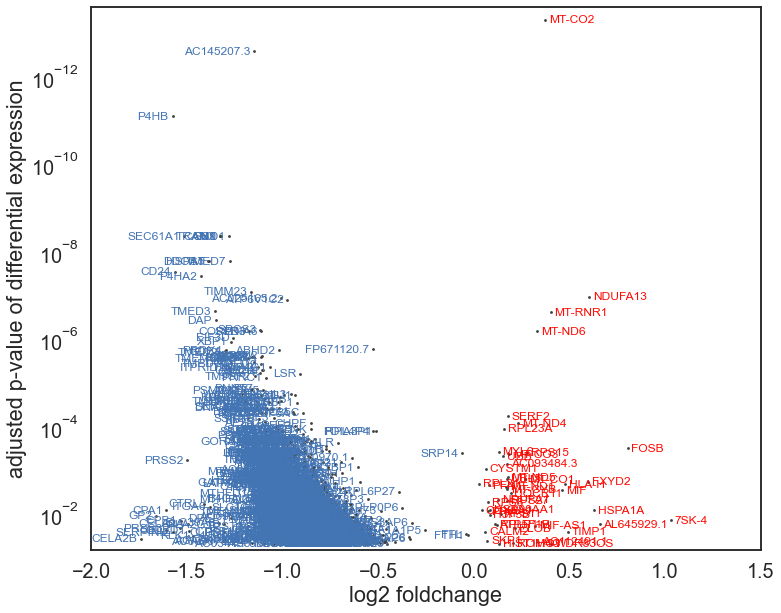

In [19]:
# plotting
[fig,ax]=plotVolcano(DEGs_Cryptic_10,fontSize=12)
fig.savefig('./../../figures/publicationFigures/DEGs/VolcanoPlotEnge_t10.pdf', bbox_inches = "tight")

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


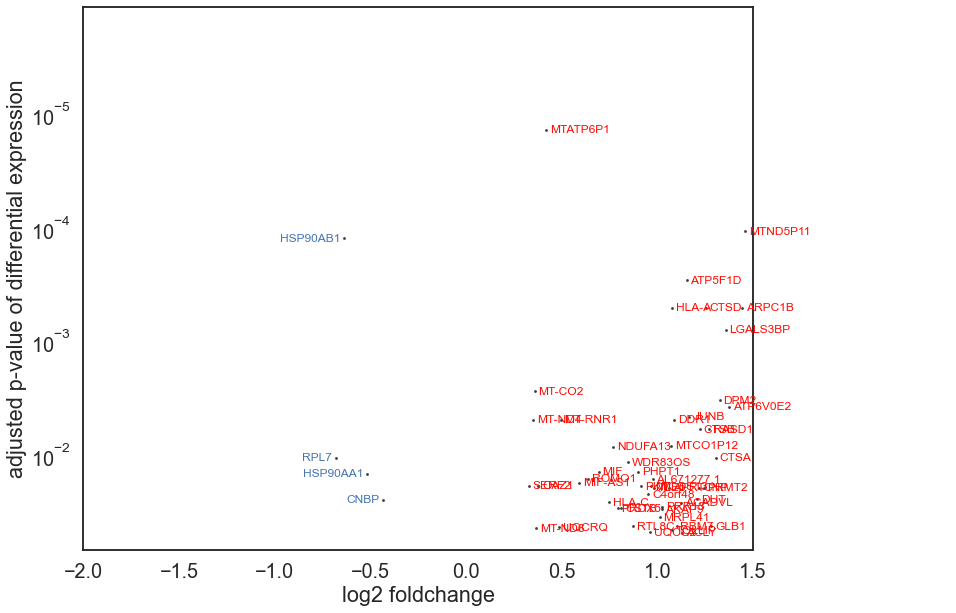

In [20]:
# plotting
[fig,ax]=plotVolcano(DEGs_Cryptic_30,fontSize=12)
fig.savefig('./../../figures/publicationFigures/DEGs/VolcanoPlotEnge_t30.pdf', bbox_inches = "tight")

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


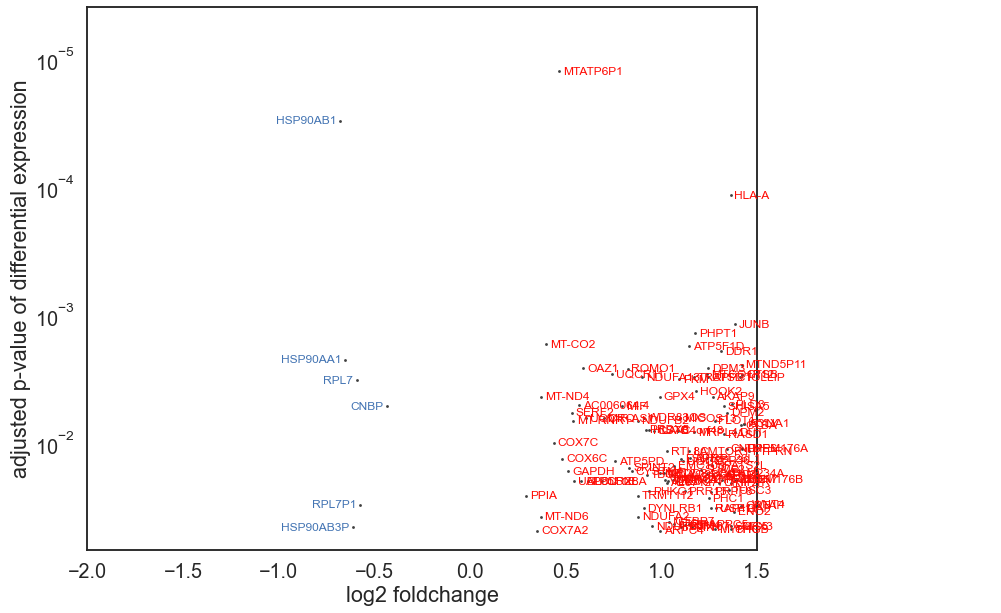

In [21]:
# plotting
[fig,ax]=plotVolcano(DEGs_Cryptic_40,fontSize=12)
fig.savefig('./../../figures/publicationFigures/DEGs/VolcanoPlotEnge_t40.pdf', bbox_inches = "tight")

/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/opt/anaconda3/envs/SC/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


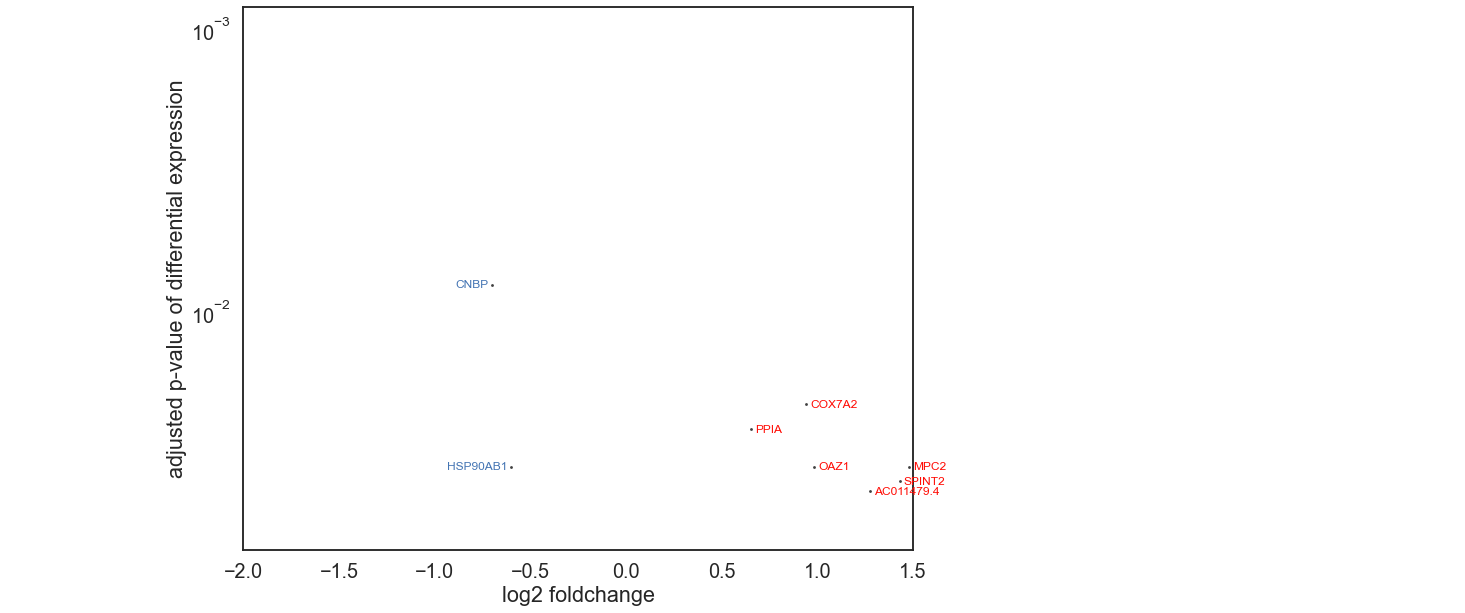

In [22]:
# plotting
[fig,ax]=plotVolcano(DEGs_Cryptic_95,fontSize=12)
fig.savefig('./../../figures/publicationFigures/DEGs/VolcanoPlotEnge_t95.pdf', bbox_inches = "tight")